# Develop a hand gesture recognition model that can accurately identify and classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture-based control systems.

## 1) Import necessary librairies

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import mediapipe as mp

## 2) Loading and preparing data

Dataset's link : https://www.kaggle.com/datasets/gti-upm/leapgestrecog

In [2]:
# Chemin du dataset
dataset_path = 'leapGestRecog'

# Les 10 gestes
gesture_names = ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', 
                 '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']

X = []
y = []

## 3) Data Exporation

In [3]:
# Going through every subfolder
for person_folder in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person_folder)
    
    if not os.path.isdir(person_path):
        continue
    
    # Going through every gesture folder
    for gesture_idx, gesture_name in enumerate(gesture_names):
        gesture_path = os.path.join(person_path, gesture_name)
        
        if not os.path.exists(gesture_path):
            continue
        
        # Going through every image in the gesture folder
        for img_file in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_file)
            
            # Get the image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                # Redimension to 64x64
                img_resized = cv2.resize(img, (64, 64))
                X.append(img_resized)
                y.append(gesture_idx)  # 0 to 9

In [4]:
# Convert into numpy arrays
X = np.array(X)
y = np.array(y)

In [5]:

print(f"\nTotal images crgées: {len(X)}")
print(f"\nShape of the images: {X.shape}")
print(f"\nNumber of classes: {len(np.unique(y))}")
print(f"\nDistribution of classes: {np.bincount(y)}")


Total images crgées: 20000

Shape of the images: (20000, 64, 64)

Number of classes: 10

Distribution of classes: [2000 2000 2000 2000 2000 2000 2000 2000 2000 2000]


## 4) Data preprocessing

In [6]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
print(f"\nTrain set: {len(X_train)} images")
print(f"\nTest set: {len(X_test)} images")


Train set: 16000 images

Test set: 4000 images


In [8]:
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1) / 255.0  # Shape: (16000, 1, 64, 64)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1) / 255.0
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 5) Modelisation / CNN

In [10]:
class HandGestureCNN(nn.Module):
    def __init__(self):
        super(HandGestureCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # 64x64 -> 32x32
        x = self.pool(self.relu(self.conv2(x)))  # 32x32 -> 16x16
        x = self.pool(self.relu(self.conv3(x)))  # 16x16 -> 8x8
        
        x = x.view(-1, 128 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [11]:
# Initialiser the model, loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

model = HandGestureCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Device: cuda


## 6) Train the model

In [12]:
epochs = 10
train_losses = []
train_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")


Epoch [1/10] - Loss: 0.7303 - Accuracy: 74.19%
Epoch [2/10] - Loss: 0.1220 - Accuracy: 95.62%
Epoch [3/10] - Loss: 0.0660 - Accuracy: 97.59%
Epoch [4/10] - Loss: 0.0589 - Accuracy: 97.84%
Epoch [5/10] - Loss: 0.0395 - Accuracy: 98.72%
Epoch [6/10] - Loss: 0.0339 - Accuracy: 98.81%
Epoch [7/10] - Loss: 0.0300 - Accuracy: 98.94%
Epoch [8/10] - Loss: 0.0296 - Accuracy: 99.02%
Epoch [9/10] - Loss: 0.0272 - Accuracy: 99.01%
Epoch [10/10] - Loss: 0.0252 - Accuracy: 99.07%


## 7) Testing the model

In [13]:
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

# Results
accuracy = accuracy_score(y_true_list, y_pred_list)
print(f"\nTest Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_true_list, y_pred_list, target_names=gesture_names))



Test Accuracy: 100.00%

Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       400
         02_l       1.00      1.00      1.00       400
      03_fist       1.00      1.00      1.00       400
04_fist_moved       1.00      1.00      1.00       400
     05_thumb       1.00      1.00      1.00       400
     06_index       1.00      1.00      1.00       400
        07_ok       1.00      1.00      1.00       400
08_palm_moved       1.00      1.00      1.00       400
         09_c       1.00      1.00      1.00       400
      10_down       1.00      1.00      1.00       400

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000



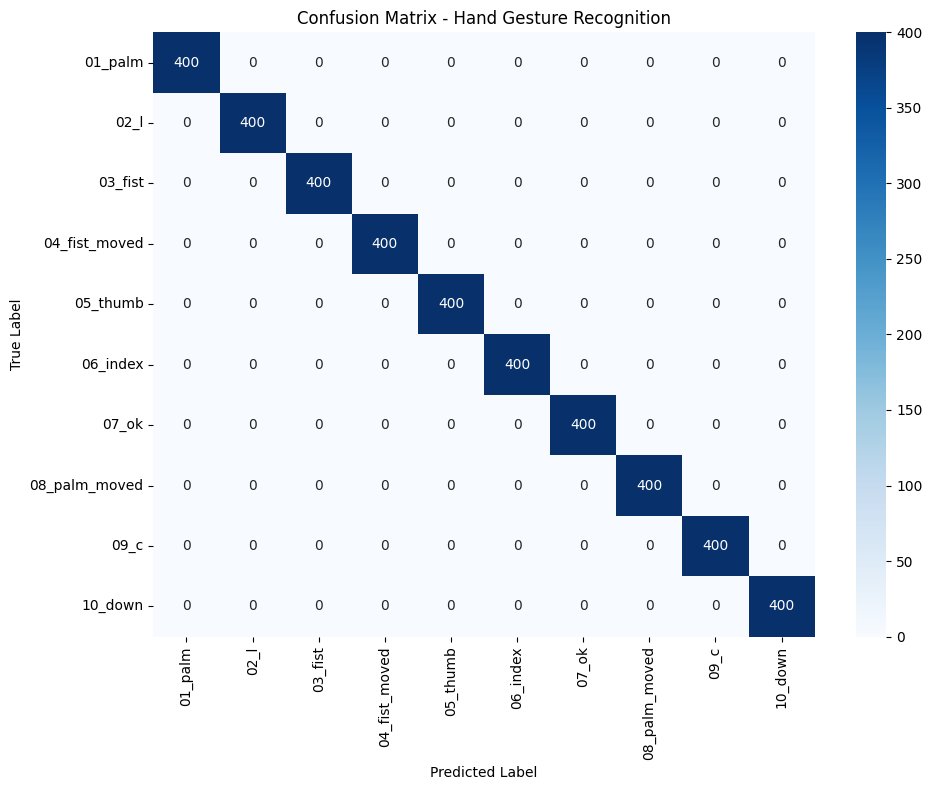

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true_list, y_pred_list)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.title('Confusion Matrix - Hand Gesture Recognition')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [15]:
torch.save(model.state_dict(), 'hand_gesture_pytorch.pth')
print("\nModel saved as: hand_gesture_pytorch.pth")


Model saved as: hand_gesture_pytorch.pth


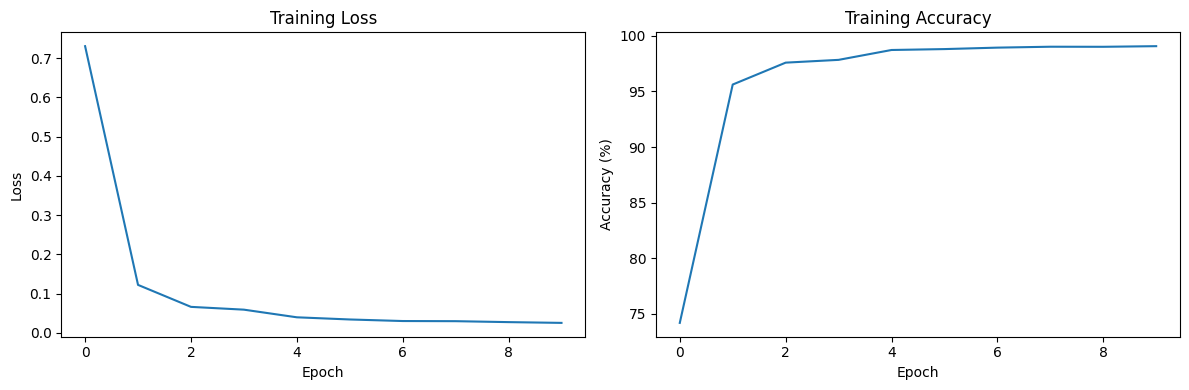

In [16]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

In [17]:
print(dir(mp))

['CalculatorGraph', 'GraphInputStreamAddMode', 'Image', 'ImageFormat', 'ImageFrame', 'Matrix', 'Packet', 'Timestamp', 'ValidatedGraphConfig', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'calculators', 'packet_creator', 'packet_getter', 'resource_util', 'solutions', 'tasks']


In [18]:
# Initialise MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.5
)


In [19]:

# Loading the PyTorch model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HandGestureCNN().to(device)
model.load_state_dict(torch.load('hand_gesture_pytorch.pth', map_location=device))
model.eval()

gesture_names = ['Palm', 'L', 'Fist', 'Fist Moved', 'Thumb', 
                 'Index', 'OK', 'Palm Moved', 'C', 'Down']

prediction_buffer = deque(maxlen=5)


C:\Users\bella\AppData\Local\Temp\ipykernel_10684\1956616772.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('hand_gesture_pytorch.pth',

In [20]:

def extract_hand_region(frame, hand_landmarks):
    """Extract the hand region from the frame based on the hand landmarks."""
    h, w, _ = frame.shape
    
    # Obtain the min/max coordinates of the landmarks
    x_coords = [landmark.x * w for landmark in hand_landmarks.landmark]
    y_coords = [landmark.y * h for landmark in hand_landmarks.landmark]
    
    x_min, x_max = int(min(x_coords)), int(max(x_coords))
    y_min, y_max = int(min(y_coords)), int(max(y_coords))
    
    # Add a margin around the hand region
    margin = 40
    x_min = max(0, x_min - margin)
    y_min = max(0, y_min - margin)
    x_max = min(w, x_max + margin)
    y_max = min(h, y_max + margin)
    
    return x_min, y_min, x_max, y_max



In [21]:
def predict_gesture(hand_roi):
    """Predict the gesture from a hand region of interest."""
    # Convert to grayscale
    gray = cv2.cvtColor(hand_roi, cv2.COLOR_BGR2GRAY)
    
    # Redimension to 64x64
    resized = cv2.resize(gray, (64, 64))
    
    # Convert to tensor
    img_tensor = torch.FloatTensor(resized).unsqueeze(0).unsqueeze(0) / 255.0
    img_tensor = img_tensor.to(device)
    
    # Prediction
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.softmax(output, 1)[0]
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class].item()
    
    # Smoothing predictions with a buffer
    prediction_buffer.append(predicted_class)
    if len(prediction_buffer) == 5:
        smoothed_prediction = max(set(prediction_buffer), key=prediction_buffer.count)
    else:
        smoothed_prediction = predicted_class
    
    return smoothed_prediction, confidence


In [22]:

def main():
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("error: Could not open webcam")
        return
    
    print("Starting real-time hand gesture recognition...")
    print("Show your hand to the camera")
    print("Press 'q' to quit")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Flip for better UX
        frame = cv2.flip(frame, 1)
        h, w, _ = frame.shape
        
        # Convert to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Draw landmarks
                mp_drawing.draw_landmarks(
                    frame, 
                    hand_landmarks, 
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 255, 255), thickness=2, circle_radius=3),
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)
                )
                
                # Extract hand region
                x_min, y_min, x_max, y_max = extract_hand_region(frame, hand_landmarks)
                
                # Draw rectangle around hand
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
                
                # Extract the ROI
                hand_roi = frame[y_min:y_max, x_min:x_max]
                
                if hand_roi.size > 0:
                    # Making prediction
                    predicted_class, confidence = predict_gesture(hand_roi)
                    gesture = gesture_names[predicted_class]
                    
                    # Show prediction with confidence
                    text = f"{gesture} {confidence:.0%}"
                    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)[0]
                    
                    # Background for text
                    cv2.rectangle(frame, 
                                (x_min, y_min - 50), 
                                (x_min + text_size[0] + 20, y_min - 10),
                                (0, 255, 0) if confidence > 0.7 else (0, 165, 255), 
                                -1)
                    
                    # Text
                    cv2.putText(frame, text, 
                              (x_min + 10, y_min - 20),
                              cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 3)
        else:
            # No hand detected
            cv2.putText(frame, "No hand detected", (20, 50),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Instructions
        cv2.putText(frame, "Press 'q' to quit", (20, h - 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Display the resulting frame
        cv2.imshow('Hand Gesture Recognition with MediaPipe', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    hands.close()
    print("Exiting...")



In [23]:
if __name__ == "__main__":
    main()

Starting real-time hand gesture recognition...
Show your hand to the camera
Press 'q' to quit
Exiting...
